<a href="https://colab.research.google.com/github/ch00226855/CMP414765Spring2021/blob/main/Week15_NeuralNetworkForRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 15
# Deep Learning for Regression

So far, we have seen how neural networks are used for classification tasks, such as image classification, text classification, text generation. Today we will apply the neural network model to a regression task.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.4.1


## Load Auto MPG Dataset

This dataset is available from the [Kaggle.com](https://www.kaggle.com/uciml/autompg-dataset)

**Please follow the steps below to download this dataset to the Colab environment:**

1. Go to your Kaggle account, Scroll to API section and Click **Expire API Token** to remove previous tokens.

2. Click on **Create New API Token** - It will download `kaggle.json` file on your machine.

In [1]:
# 3. Install the kaggle API
! pip install kaggle

In [2]:
# 4. Upload the kaggle.json file
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ch00226855","key":"303caa3b86b2452b5785afacfebcf38c"}'}

In [3]:
# 5. Make a directory named kaggle and copy kaggle.json file there
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permission of the file
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 6. Download and unzip the dataset
!kaggle datasets download -d uciml/autompg-dataset
!unzip autompg-dataset.zip

  0% 0.00/6.31k [00:00<?, ?B/s]
100% 6.31k/6.31k [00:00<00:00, 5.93MB/s]
Archive:  autompg-dataset.zip
  inflating: auto-mpg.csv            


## Attribute Information

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

The goal of this project is to train a model that predicts "MPG" using other features.

In [7]:
# Load the dataset
filename = 'auto-mpg.csv'
dataset = pd.read_csv(filename,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [10]:
# Drop the "car name" column, as the model tries to find the general relationship between mpg and 
# other factors.
dataset = dataset.drop(['car name'], axis=1)
# Alternative statements:
# dataset.drop(['car name'], axis=1, inplace=False)
# dataset.drop(columns=['car name'], inplace=False)
# dataset = dataset.iloc[:, :8]
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


## Data Preprocessing
- Check for missing values
- Handle categorical features
- Split into training and test set

In [18]:
# Are there any missing values?
# If so, how should we handle them?
dataset.isnull().sum().sort_values(ascending=False)

horsepower      6
origin          0
model year      0
acceleration    0
weight          0
displacement    0
cylinders       0
mpg             0
dtype: int64

In [19]:
dataset.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [21]:
# Consider using mean or median to fill the missing values
# Find the six rows where horsepower is missing, and put the mean value 104.47 there.
dataset['horsepower'] = dataset['horsepower'].fillna(104.47)

# It seems working, but how can we make sure?
dataset.isnull().sum().sort_values(ascending=False)

origin          0
model year      0
acceleration    0
weight          0
horsepower      0
displacement    0
cylinders       0
mpg             0
dtype: int64

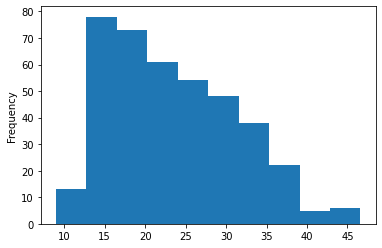

In [22]:
# We probably want to see the distribution of the data.
# For example, we can draw a histogram of the mpg column:
dataset['mpg'].plot.hist()

In [23]:
# The "Origin" column is really categorical, not numeric. 
dataset['origin'] = dataset['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,USA
1,15.0,8,350.0,165.0,3693,11.5,70,USA
2,18.0,8,318.0,150.0,3436,11.0,70,USA
3,16.0,8,304.0,150.0,3433,12.0,70,USA
4,17.0,8,302.0,140.0,3449,10.5,70,USA


In [24]:
# One-hot encoding:
#         IsUSA    |   IsEurope  | IsJapan
# USA:      1      |        0    |     0
# Europe:   0      |        1    |     0
# Japan:    0      |        0    |     1

dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449,10.5,70,0,0,1


In [25]:
# Split the data into df_train (60%), df_validation (20%), and df_test (20%)
from sklearn.model_selection import train_test_split
df_train, temp = train_test_split(dataset, test_size=0.4)
df_validation, df_test = train_test_split(temp, test_size=0.5)

print("Train set:", df_train.shape)
print("Test set:", df_test.shape)
print("Validation set:", df_validation.shape)

Train set: (238, 10)
Test set: (80, 10)
Validation set: (80, 10)


## Inspect the Data
- Inspect the distribution of each individual feature:
    - descriptive statistics
    - histogram
- Inspect the relationship between features:
    - correlation coefficients
    - scatter plots

In [26]:
# Compute descriptive statistices: min, max, mean, median, standard deviation
df_train.describe()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,Europe,Japan,USA
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.00000
mean,23.497899,5.491597,192.413866,103.667563,2965.567227,15.665966,75.970588,0.142857,0.231092,0.62605
std,7.862604,1.695717,100.965392,36.994331,825.720482,2.814575,3.658868,0.350665,0.422420,0.48487
min,10.000000,3.000000,70.000000,46.000000,1613.000000,8.500000,70.000000,0.000000,0.000000,0.00000
25%,17.500000,4.000000,105.000000,76.000000,2220.000000,13.825000,73.000000,0.000000,0.000000,0.00000
50%,22.000000,4.000000,151.000000,95.000000,2844.000000,15.500000,76.000000,0.000000,0.000000,1.00000
75%,29.375000,8.000000,260.000000,124.250000,3616.250000,17.300000,79.000000,0.000000,0.000000,1.00000
max,44.600000,8.000000,455.000000,225.000000,4955.000000,24.800000,82.000000,1.000000,1.000000,1.00000


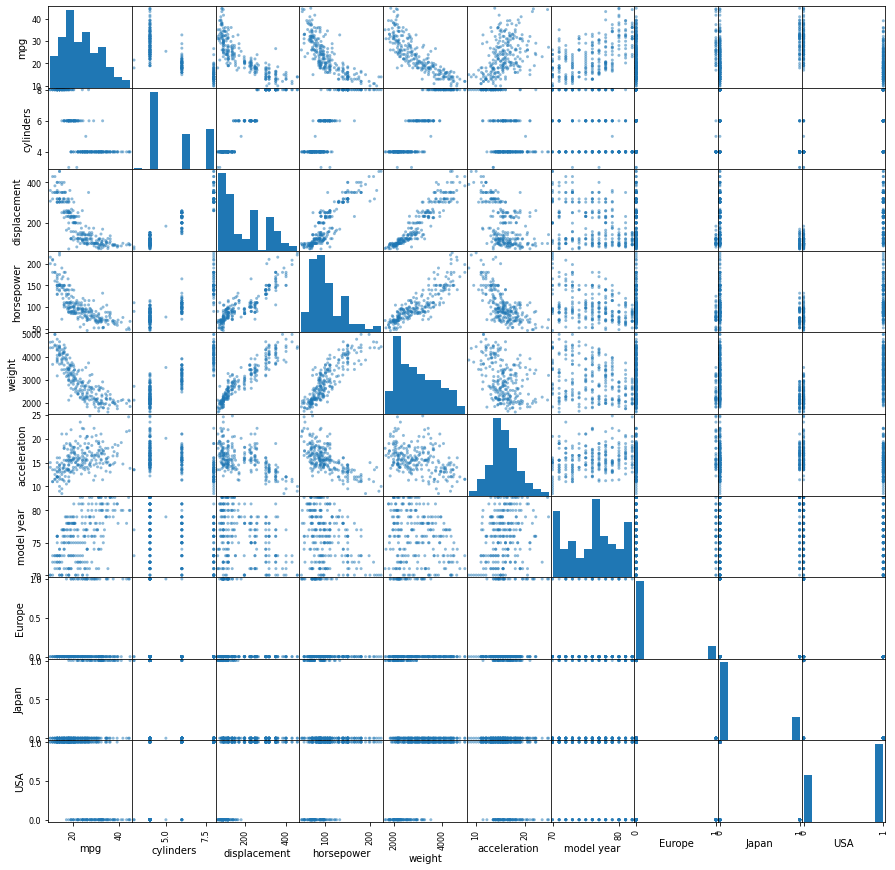

In [27]:
# Plot histogram and pairwise scatter plots for numerical variables
pd.plotting.scatter_matrix(df_train, figsize=(15, 15))
plt.show()

In [ ]:
# Calculate the correlation coefficient between MPG and every other feature



## Build the Model
- Transform data into proper format
- Normalize data
- Build neural network
- Specify loss function and training method

In [28]:
# Separate the "MPG" feature from the rest.
df_train_labels = df_train['mpg']
# df_train_data = df_train.loc[:, ['Cylinders', 'Displacement',...]]
df_train_data = df_train.iloc[:, 1:]
df_train_data.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,Europe,Japan,USA
192,6,250.0,105.0,3353,14.5,76,0,0,1
268,4,119.0,97.0,2300,14.7,78,0,1,0
254,6,200.0,85.0,2965,15.8,78,0,0,1
67,8,429.0,208.0,4633,11.0,72,0,0,1
301,4,105.0,70.0,2200,13.2,79,0,0,1


In [ ]:
# Perform this transformation to the validation set and the test set.




In [29]:
# Normalize the data by applying the following tranformation:
# x <-- (x - mean) / std
# Result of this transform:
#   1. the average value of each column will be 0.
#   2. the standard deviation of each column will be 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(df_train_data)
df_train_scaled

array([[ 0.300448  ,  0.57155719,  0.03609323, ..., -0.40824829,
        -0.54822117,  0.77286185],
       [-0.88147967, -0.72865149, -0.18061186, ..., -0.40824829,
         1.82408134, -1.29389231],
       [ 0.300448  ,  0.07529434, -0.5056695 , ..., -0.40824829,
        -0.54822117,  0.77286185],
       ...,
       [ 1.48237567,  1.24647468,  1.25505938, ..., -0.40824829,
        -0.54822117,  0.77286185],
       [ 1.48237567,  2.06034577,  1.25505938, ..., -0.40824829,
        -0.54822117,  0.77286185],
       [ 0.300448  ,  0.39290256, -0.37022881, ..., -0.40824829,
        -0.54822117,  0.77286185]])

In [31]:
# Don't forget to use the same scaler to transform the validation set and the test set
df_validation_data = df_validation.iloc[:, 1:]
df_validation_label = df_validation['mpg']
df_validation_scaled = scaler.transform(df_validation_data) # No need to fit since it will alter the means and stds
df_validation_scaled



array([[-0.88147967, -1.12566178, -0.99325595, -1.17182771,  0.11893006,
        -0.53971367,  2.44948974, -0.54822117, -1.29389231],
       [ 1.48237567,  1.10752108,  2.41984925,  2.14377085,  1.00903556,
        -1.63525187, -0.40824829, -0.54822117,  0.77286185],
       [-0.88147967, -0.57977264, -0.20769999, -0.31986937, -0.77117544,
        -0.26582912, -0.40824829,  1.82408134, -1.29389231],
       [-0.88147967, -0.86760509, -0.77655086, -0.89269606, -0.41513324,
         0.55582453, -0.40824829, -0.54822117,  0.77286185],
       [-0.88147967, -0.75842727, -0.37022881, -1.02255296, -0.59315434,
        -1.36136732,  2.44948974, -0.54822117, -1.29389231],
       [-0.88147967, -0.94700715, -0.42440509, -1.01405765, -0.41513324,
        -1.63525187, -0.40824829,  1.82408134, -1.29389231],
       [-0.88147967, -1.02640921, -1.12869664, -1.35993817, -0.13029948,
         1.10359362,  2.44948974, -0.54822117, -1.29389231],
       [-0.88147967, -0.52022109, -0.85781527, -0.68516775,  1

In [ ]:
# Build a 3-layer neural network:
# 1. input layer (what is the input shape?)
# 2. hidden layer with 64 nodes and ReLU activation
# 3. output layer (what is the output shape?)



In [ ]:
# Display a summary of the model



In [ ]:
# Use model.compile() to specify:
# 1. loss = 'mse'
# 2. optimizer = tf.keras.optimizers.RMSprop(0.001)
# 3. metrics = ['mae', 'mse']



## Train the Model
- Train the model
- Analyze the loss curve
- Improve the model

In [ ]:
EPOCHS = 1000

history = model.fit(
  df_train_scaled, df_train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
)

In [ ]:
# Visualize the model's training progress using the statistics stored in
# the "history" object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

In [ ]:
# Plot training MAE and validation MAE against epochs



In [ ]:
# Plot training MSE and validation MSE against epochs



## Evaluate the Model
- Evaluate the model on the test set
- Visualize the predictions

In [ ]:
# Evalute the performance on the test set



In [ ]:
# Visualize model predictions against true values



In [ ]:
# Plot the histogram of prediction errors

